<a href="https://colab.research.google.com/github/HyunSoo-Lee/Pyeongchang_Hackerton/blob/Emergency-Sound-data-analysis/Scream_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q pydub

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import numpy as np
from scipy.io import wavfile 
import librosa
import random
import pydub
import librosa.display

In [ ]:
def absolute_file_paths(directory): #setting path
    path = os.path.abspath(directory)
    return [entry.path for entry in os.scandir(path) if entry.is_file()]

scream_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/낙상')
non_scream_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/붕괴')
atmospheric_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/atmospheric_data')

In [ ]:
all_paths = []
all_labels = []

for scream in scream_paths:
    label = 'scream'
    all_paths.append(scream)
    all_labels.append(label)

for non_scream in non_scream_paths:
    label = 'non_scream'
    all_paths.append(non_scream)
    all_labels.append(label)

for atmos in atmospheric_paths:
    label = 'atmospheric'
    all_paths.append(atmos)
    all_labels.append(label)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(all_labels)
labels.shape

(858, 3)

In [ ]:
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(all_paths ,labels ,test_size=0.3,random_state=0)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

600
258
600
258


In [ ]:
def get_signal(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    return audio, sample_rate

X_train_signal = []
for audio in X_train:
    signal , sr =  get_signal(audio)
    X_train_signal.append([signal, sr])
    

In [ ]:
def data_aug(signal, sample_rate):

    noise_factor = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
    stretch_rate = [0.6, 0.65, 0.7, 0.75, 0.8]
    num_semitones = [-2,-1, 0, 1, 2]

    noise = np.random.normal(0,signal.std(), signal.size)  # Noise vector created using Gaussian Distribution

    augmented_1 =  signal + noise * random.choice(noise_factor)

    augmented_2 =  librosa.effects.time_stretch(augmented_1, random.choice(stretch_rate))

    augmented_3 =  librosa.effects.pitch_shift(augmented_2 , sample_rate , random.choice(num_semitones))

    return augmented_3, sample_rate

augmented_signals = []
for signals in X_train_signal:

    signal = signals[0]
    sample_rate = signals[1]
    augmented_signal, sample_rate = data_aug(signal, sample_rate)
    augmented_signals.append([augmented_signal, sample_rate])

In [ ]:
augmented_signals = np.asarray(augmented_signals)
X_train_signal   = np.asarray(X_train_signal)

print(augmented_signals.shape)
print(X_train_signal.shape)

new_X_train = np.concatenate((augmented_signals, X_train_signal), axis=0)
print(new_X_train.shape)

(600, 2)
(600, 2)
(1200, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
y_train_1 = np.copy(y_train)
new_y_train = np.concatenate((y_train, y_train_1), axis=0)

print(new_y_train.shape)

(1200, 3)


In [ ]:
def features_extractor(audio, sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60) #spectogram? feature engineering for audio
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) #scaling, mean , standardization?
    
    return mfccs_scaled_features

X_train_features = []
for x in new_X_train:
    #new_X_train_features = features_extractor()
    audio = x[0]
    sample_rate = x[1]
    mfccs_scaled_features = features_extractor(audio, sample_rate)
    X_train_features.append(mfccs_scaled_features)

In [ ]:
X_train_features = np.asarray(X_train_features)
X_train_features.shape

(1200, 60)

In [ ]:
def features_extractor_test(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') #loading audio files, #sample rate- numerical int value of each music file
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60) #spectogram? feature engineering for audio
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) #scaling, mean , standardization?
    
    return mfccs_scaled_features

X_test_features = []
for x in X_test:
    data = features_extractor_test(x)
    X_test_features.append(data)

X_test_features = np.asarray(X_test_features)
X_test_features.shape

(258, 60)

In [ ]:
print(X_train_features.shape)
print(new_y_train.shape)
print(X_test_features.shape)
print(y_test.shape)

(1200, 60)
(1200, 3)
(258, 60)
(258, 3)


In [ ]:
num_labels = y_test.shape[1]

In [ ]:
model=Sequential() 

###first layer
model.add(Dense(128,input_shape=(60,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train_features, new_y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_features, y_test), callbacks=[checkpointer],
          verbose=1, shuffle = True)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
25/38 [==================>...........] - ETA: 0s - loss: 16.0484 - accuracy: 0.4363
Epoch 1: val_loss improved from inf to 0.72572, saving model to saved_models/audio_classification.hdf5
38/38 [==============================] - 1s 11ms/step - loss: 13.8344 - accuracy: 0.4458 - val_loss: 0.7257 - val_accuracy: 0.8062
Epoch 2/200
35/38 [==========================>...] - ETA: 0s - loss: 4.8810 - accuracy: 0.4607
Epoch 2: val_loss improved from 0.72572 to 0.69040, saving model to saved_models/audio_classification.hdf5
38/38 [==============================] - 0s 5ms/step - loss: 4.8322 - accuracy: 0.4608 - val_loss: 0.6904 - val_accuracy: 0.5698
Epoch 3/200
36/38 [===========================>..] - ETA: 0s - loss: 2.7841 - accuracy: 0.4913
Epoch 3: val_loss did not improve from 0.69040
38/38 [==============================] - 0s 4ms/step - loss: 2.8020 - accuracy: 0.4875 - val_loss: 0.7158 - val_accuracy: 0.6240
Epoch 4/200
35/38 [==========================>...] - ETA: 0s - loss:

In [ ]:
test_accuracy=model.evaluate(X_test_features,y_test,verbose=0)
print(test_accuracy)

[0.02635153941810131, 0.9922480583190918]


In [ ]:
predictions = model.predict(x=X_test_features)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

 atmospheric       1.00      1.00      1.00        17
  non_scream       1.00      0.98      0.99       115
      scream       0.98      1.00      0.99       126

    accuracy                           0.99       258
   macro avg       0.99      0.99      0.99       258
weighted avg       0.99      0.99      0.99       258



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46108 missing from current font.
  font.set_

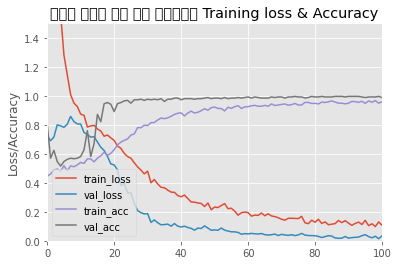

In [ ]:
N =200
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.ylim(0,1.5)
plt.xlim(0,100)
plt.title("소음이 합성된 음성 파일 데이터셋의 Training loss & Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plotPath = r'E:\Rohan\Sem 7\Minor Project\Major Project\Model'
plt.show()

In [ ]:
def predict(file):

	audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 

	mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
	mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
	mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

	labels = ['atmospheric', 'non_scream', 'scream']
	labels.sort()
	predict_x=model.predict(mfccs_scaled_features) 
	classes_x=np.argmax(predict_x,axis=1)

	return labels[classes_x[0]]

test_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/test')

for test in test_paths:
    label = 'scream'
    title = test.split('/test/')[1]
    predicted_list = predict(test)
    print("예상:",predicted_list, "파일명:", title)

1/1 [==============================] - 0s 25ms/step
예상: scream 파일명: scream.wav
1/1 [==============================] - 0s 23ms/step
예상: non_scream 파일명: WhatsApp Ptt 2022-01-17 at 18.55.22.wav


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7808      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [ ]:
model.save('scream.h5')

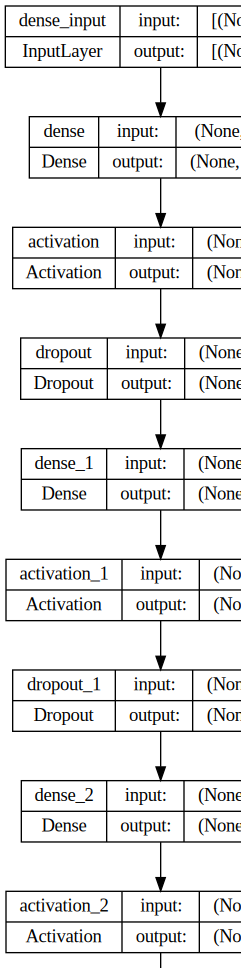

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))